<a href="https://colab.research.google.com/github/jchou03/Natural-Language-Processing/blob/main/CS505_PA3_Jared_Chou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this piece of code, we are going to process and analyze the data we collect from Twitter, Wikipedia, ABC and Fox news.

Prior to this assignment, please make sure you have implemented the scraping functions so that you could scrap data from the Wikipedia, ABC and Fox news pages.



Task 1. With your implemented code provided in the first lab section, get the "article" texts of the wikipedia page of "fishing" and its all linked wiki pages. Your saved data should contain the titles of the wiki pages and their article texts.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
import csv
from bs4 import BeautifulSoup
csv.field_size_limit(sys.maxsize)
import requests
import time # for setting up a delay on getting htmls from wiki server.
from tqdm import tqdm

# Here is a function you could load the text data if your saved data follows
# the format we provide the in first lab section code.

def loadWikiTexts(csvPath):
  wikiRawTextDict = {}
  with open(csvPath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      wikiRawTextDict[row['wikiTitle']] = row['wikiContents']
  return wikiRawTextDict

def writeWikiTexts(pathToSave, infoDict):
  with open(pathToSave, 'w', newline='') as csvfile:
    fieldnames = ['idx','wikiTitle', 'wikiContents']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i,wikiContentKey in enumerate(infoDict.keys()):
      writer.writerow({'idx': i, 'wikiTitle': wikiContentKey,'wikiContents': infoDict[wikiContentKey]})

# Load your wiki text data here
# First, get the page info from wiki server given an URL.
def getPageFromWiki(url):
  # you should return a soup object with the specified URL
  # IMPLEMENT YOUR CODE HERE: #
  r = requests.get(url)
  soup = BeautifulSoup(r.content, 'html.parser')
  return soup

# Second, get the title of the wiki page
def getHeading(soup):
  heading = ""
  # you should return the title of the wiki page with the soup object you initiated from getPageFromWiki
  heading = soup.select_one('#firstHeading').text.strip()
  return heading

# Third, get the article part of the wiki page 
def getContent(page):
  content = ""
  # you should return the article part of the wiki page with the soup object you initiated from getPageFromWiki
  # since there are multiple paragraphs, you should merge them together into one long string.
  # IMPLEMENT YOUR CODE HERE: #
  paragraphs = page.select('#content p')
  for p in paragraphs:
    content += p.text.strip()
  return content

# Fourth, get the links that the article part mentioned and specifically, linking to other wiki pages.
def getLinks(page):
  linksDict = {}
  # you should return the links mentioned in article part of the wiki page with the soup object you initiated from getPageFromWiki
  # you should return a dictionary, with keys are the titles of the linked pages, and the values are the links.
  # IMPLEMENT YOUR CODE HERE: #
  links = page.select('#bodyContent a[href^="/wiki/"]') # https://www.w3.org/TR/selectors-3/#pseudo-elements
  link_start = "https://en.wikipedia.org"
  for link in links:
    keys = list(link.attrs.keys())
    if ('title' in keys and not 'Category' in link['title']):
      if not ('class' in keys and ('external text' in link['class'] or 'mw-redirect' in link['class'])):
        linksDict[link.text] = (link_start + link['href'])
        # print(link.text)
  return linksDict

In [101]:
# define path to the fishing data
driveFolderDirectory = "" # '/content/drive/MyDrive/Sophomore(22-23)/CS505/CS505_Data/PA2/' # if your are not using Google Colab, edit the value directly here.
savedFileName = 'fishingContents.csv'
pathToSave = driveFolderDirectory + savedFileName

In [104]:
# scrape and save the data in google drive we need to recreate it (don't need to run every)
pageDict = {}

page = getPageFromWiki('https://en.wikipedia.org/wiki/Fishing') # scrap the main page we want. 
header = getHeading(page)
content = getContent(page)
pageDict[header] = content
# print(pageDict)
linksDict = getLinks(page) # get the links contained in the article part of the page.
print("a set of {} links are found.".format(len(linksDict)))

# print(linksDict)

for title in tqdm(list(linksDict.keys())): # set up a loop to , set a delay at each iteration
  url = linksDict[title]
  page = getPageFromWiki(url)
  header = getHeading(page)
  content = getContent(page)
  pageDict[header] = content
  time.sleep(1) # Remember to set a delay >=1 second so you won't break the server.

print("a size of {} content dictionary is built.".format(len(pageDict)))

a set of 398 links are found.


100%|██████████| 398/398 [09:03<00:00,  1.37s/it]

a size of 318 content dictionary is built.


In [105]:
# save the wiki information to drive
# print(pageDict)
writeWikiTexts(pathToSave, pageDict)

In [106]:
# load the fishing data
# print(driveFolderDirectory + savedFileName)
fish_texts = loadWikiTexts(driveFolderDirectory + savedFileName)
# print(fish_texts)

Task 2. With library Spacy and Regular Expression (re), preprocess our scraped data to:

- Remove all the references texts [...] in the scraped data  ([re](https://docs.python.org/3/library/re.html)). 
- [Sentence split](https://spacy.io/usage/linguistic-features#sbd) (Spacy).
- [Tokenize](https://spacy.io/usage/linguistic-features#tokenization) (Spacy)
- [Lemmatize](https://spacy.io/usage/linguistic-features#lemmatization) (Spacy)
- [Lower case](https://www.programiz.com/python-programming/methods/string/lower) (String)


In [107]:
# install spacy and related package(s)

!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 47.5 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
numba 0.56.2 requires setuptools<60, but you have setuptools 65.4.1 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-10-06 05:15:35.127798: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [108]:
import re
import spacy
import string

def preprocess(wikiTextDict):
  # Input: a wiki text dictionary with keys are titles and values are the corresponding texts.
  # Output: a wiki text dictionary with keys are the titles and the values are the preprocessed texts 
  # (sentences - tokens).

  nlp = spacy.load('en_core_web_sm')
  pages = {}
  ref = re.compile('\[[0-9]+\]\s|\s\[[0-9]+\]')
  for page in wikiTextDict:
    val = wikiTextDict[page]
    sentences = []
    # print(val)
    # sub-task 1: remove all the references texts "[...]" 
    val = re.sub(ref, '', val)
    # sub-task 2: segment all the sentences in the wiki texts.
    page_doc = nlp(val)
    # print(page_doc.sents)
    # print(page_string)
    for sent in page_doc.sents:
      # print("sent: " + str(sent))
      # sub-task 3: tokenize the sentences from sub-task 2.
      sent_tokens = []
      for token in sent:
        # sub-task 4: lemmatize the tokens from sub-task 3.
        # sub-task 5: lower-case the tokens from sub-task 3/4.
        word = token.lemma_.lower()
        if(not word in string.punctuation):
          sent_tokens.append(word)
        
      # print(sent_tokens)
      sentences.append(sent_tokens)
    # print("sentences: " + str(sentences))
    pages[str(page).lower()] = sentences
  # You don't need to follow the order of the sub-tasks.
  return pages

In [109]:
# Preprocess your data here.
preprocessed_docs = preprocess(fish_texts)
# print(len(preprocessed_docs))
# for doc in preprocessed_docs:
#   print(preprocessed_docs[doc])
#   break

Task 3. Construct a dictionary of the vocabulary for your scraped data (all texts). The keys are the word types and the values are the count of the appearances of the word (frequency).

In [110]:
from collections import Counter

def computeFreq(wikiTextDict):
  freq_dict = {}
  # Input: a wiki text dictionary with keys are titles and values are the preprocessed corresponding texts.
  # Output: a dictionary with keys are the word types, and the values are the appearance counts of the word types
  vocab = []
  for page in wikiTextDict.values():
    # print(page)
    for sent in page:
      vocab.extend(sent)
  word_freq = Counter(vocab)
  return word_freq

# Compute the frequency dictionary here.
wikiVocabDict = computeFreq(preprocessed_docs)
# print(wikiVocabDict)

Task 4. What are the top 20 non-stop, non-punctuation words in the vocabulary according to frequency?

In [111]:
def computeTop20Words(freqDict):
  # Input: a dictionary with keys are the word types, and the values are the appearance counts of the word types
  # Output: a list of 20 words that appear most frequently in all the preprocessed scraped texts.
  return freqDict.most_common(20)
  # If not preprocessed specifically, the punctuations still exist in the frequency dictionary from task 3.
  # You need to remove them before outputing the top 20 words.

# Print your top 20 words here.
top20 = computeTop20Words(wikiVocabDict)
print(top20)

[('the', 68296), ('be', 35683), ('of', 34798), ('and', 31244), ('in', 25038), ('to', 22427), ('a', 19375), ('as', 9571), ('for', 7974), ('have', 7852), ('by', 7088), ('with', 6594), ('that', 6551), ('on', 5947), ('or', 5693), ('from', 5557), ('fish', 4295), ('use', 4182), ('which', 4092), ('it', 3949)]


Task 5. Use library such as wordcloud, [generate the word cloud](https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5) of the text to visualize the distribution of non-stop and non-punctuation words.

In [112]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


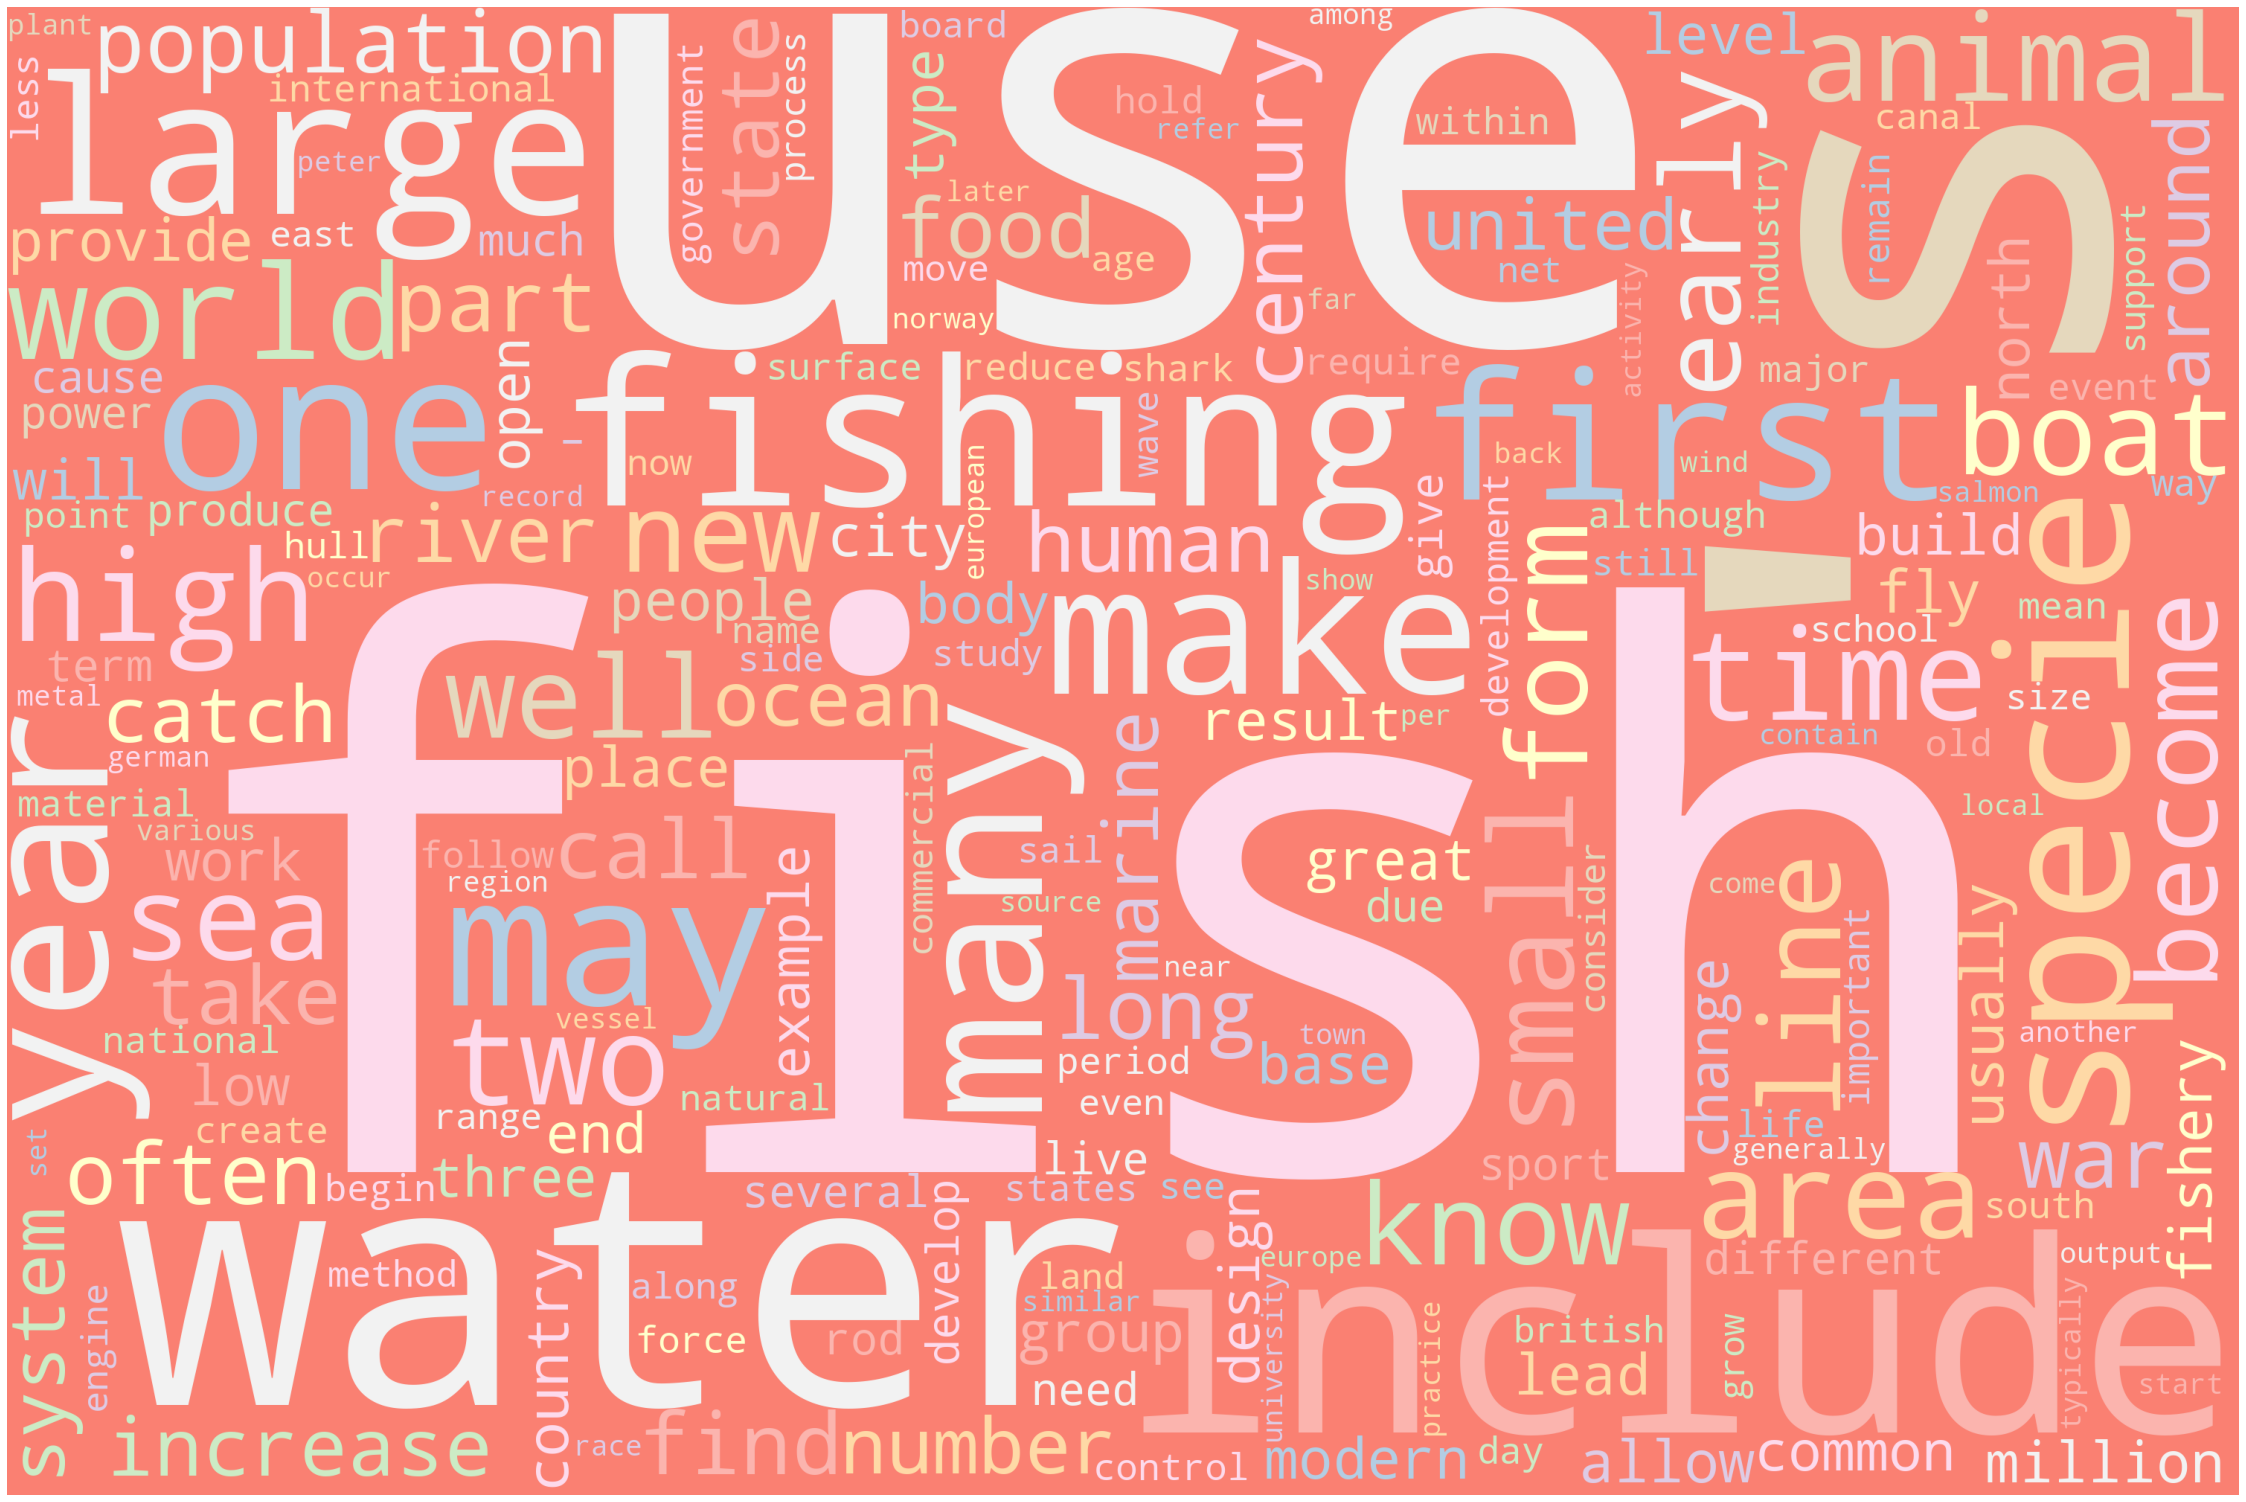

In [113]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def plotWordCloud(image):
  # Input: word cloud image
  # Output: (display the cloud image in the output)
  # Set figure size
  plt.figure(figsize=(40, 30))
  # Display image
  plt.imshow(image) 
  # No axis details
  plt.axis("off")

def generateWordCloud(text):
  # Input: all texts in the scraped wiki data.
  # Output: word cloud image.
  wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, \
                        background_color='salmon', colormap='Pastel1', \
                        collocations=False, stopwords = STOPWORDS).generate_from_frequencies(text)

  return wordcloud

# Remove all the stopwords from the dictionary of word frequencies
for word in STOPWORDS:
  wikiVocabDict.pop(word, None)
# Draw your word cloud here
wordcloud = generateWordCloud(wikiVocabDict)
plotWordCloud(wordcloud)

In [ ]:
# print(STOPWORDS)

Task 6. Preprocess the raw scraped tweets with keyword ’fishing’ you’ve collected in the last assignment in the same way as you preprocess the wiki texts.

In [114]:
# install tweepy
!pip3 install tweepy
!pip3 install tweepy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0


In [115]:
# imports & initialize client
import tweepy
import csv

client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAALZxhAEAAAAANF7xDDhnPvnIzDbG1DAgwfW%2Ft%2Bo%3DqLKehartkTnY8z7aa2uYo3doESHKL9UZhtJD0gQJiI5HxpyZDK')

In [116]:
# get all the fishing texts, and save it to a CSV in drive

query = "fishing lang:en -has:links -has:mentions -is:retweet"
fishingTweets = list(tweepy.Paginator(client.search_recent_tweets, query = query, tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=10000))
print("{} tweeets are collected".format(len(fishingTweets)))

savedFileName = "fishingTweets.csv"
pathToSave = driveFolderDirectory + savedFileName

with open(pathToSave, 'w', newline='') as csvfile:
  fieldnames = ['idx', 'tweetId', 'tweetText']
  writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
  writer.writeheader()
  for i, tweet in enumerate(fishingTweets):
    writer.writerow({'idx':i, 'tweetId':tweet.id, 'tweetText':tweet.data['text']})

8699 tweeets are collected


In [117]:
# Here is a function you could load the tweet text data if your saved data follows
# the format we provide the in last lab section code.

import csv

def loadTweetTextFromCSV(csvPath):
  tweetDict = {}
  with open(csvPath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      tweetDict[int(row['idx'])] = row['tweetText']
  return tweetDict

fishingTweetDict = loadTweetTextFromCSV(pathToSave)
processedTweetData = preprocess(fishingTweetDict) # here we assume you have implemented the preprocess function in task 2.


In [132]:
# print(processedTweetData)

Task 7. Compute how many **word types** in your tweets are out-of-vocabulary (out of Wiki vocabulary Dict), divided by the number of **word types** in your tweets. Show the value in percentage (%).

In [118]:
def computeOOVWordTypes(tweetVocabDict, wikiVocabDict):

  # Input: a dictionary of tweet data vocabulary, a dictionary of wiki data vocabulary.
  # Output: the ratio of word types in your tweets that are out-of-vocabulary w.r.t. wiki vocabulary
  # v.s. total number of word types in your tweet data.
  OOV_count = 0
  for word in tweetVocabDict:
    if not word in wikiVocabDict:
      OOV_count += 1
  # The ratio should be in percentage.
  ratio = OOV_count/len(wikiVocabDict)
  return str(ratio * 100) + "%"

# Create the vocab dict for the fishing tweets
tweetVocabDict = computeFreq(processedTweetData)
# Print your ratio here.
OOV_ratio = computeOOVWordTypes(tweetVocabDict, wikiVocabDict)
print(OOV_ratio)

14.44772500635473%


Task 8. Compute how many **word tokens** in your tweets are out of vocabulary, divided by the number of **word tokens** in your tweets. (This is the OOV-rate of your tweet test set.)

In [119]:
def computeOOVWordTokens(tweetVocabDict, wikiVocabDict):

  # Input: a dictionary of tweet data vocabulary, a dictionary of wiki data vocabulary. (E.g. computed from task 3)
  # Output: the ratio of word tokens in your tweets that are out-of-vocabulary w.r.t. wiki vocabulary
  # v.s. total number of word tokens in your tweet data.
  OOV_token_count = 0
  vocab_token_count = 0
  for word in tweetVocabDict:
    if not word in wikiVocabDict:
      OOV_token_count += tweetVocabDict[word]
  for word in wikiVocabDict:
    vocab_token_count += wikiVocabDict[word]
  # Remeber this time we count the number of tokens instead of types. The ratio should be in percentage.
  return str( (OOV_token_count / vocab_token_count)*100 ) + "%"

# Print your ratio here.
OOV_token_ratio = computeOOVWordTokens(tweetVocabDict, wikiVocabDict)
print(OOV_token_ratio)

18.332649480863104%


Task 9. Get the first 9,000 sentences from the processed Wikipedia data from task 2, train a trigram Add-one-smoothing language model based
on these 9,000 sentences (which you should have done so in the last assignment). 

(You could consider using the language model from NLTK.)


In [120]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import NgramCounter
from nltk.util import ngrams
from nltk.lm import Laplace

def trainLanguageModel(processedWikiData):
  # Input: the pre-processed wiki data
  # Output: a trigram model trained on the wiki data 
  train, vocab = padded_everygram_pipeline(order = 3, text = processedWikiData)
  # You could refer to the last assignment to implement this function.
  laplace = Laplace(order = 3)
  laplace.fit(train, vocab)
  return laplace

# Get the first 9000 sentences from the processed wiki data.
processed_sents = []
for doc in preprocessed_docs.values():
  for sent in doc:
    if(len(processed_sents) < 9000):
      processed_sents.append(sent)
# print(processed_sents)
# Train the language model with the processed data.
lm = trainLanguageModel(processed_sents)

Task 10. Report the average perplexity of this Wikipedia-trained language model on your processed Twitter test sentences (i.e. the 20% split) related to "fishing". Compare this perplexity to the one you obtained in task 4 of the last assignment, specifically, the trigram LM trained on tweets. 

In [138]:
def computePerplexity(model,testData):
  # Input: your model; the testing data
  # Output: average perplexity of the model on your testing data.
  # You may want to re-use the same function you implemented in the last assignment
  return model.perplexity(testData)

# Prepare the testing data
testing_data = []
for tweet in processedTweetData.values():
  for sent in tweet:
    if sent != []:
      testing_data.append(sent)
# print(testing_data)
# Compute and print the average perplexity of the wiki-trained model on your tweet testing data.
print("Average perplexity of wiki-trained model on tweet testing data: " + str(computePerplexity(lm, testing_data)))

Average perplexity of wiki-trained model on tweet testing data: 21137.817798741777


Task 11. Scrap 100 news from both ABC news and Fox news (100 each) with the code provided in the first lab section. Preprocess the texts in the same way as task 2.

In [123]:
#install newspaper
!pip install newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [124]:
#Try getting 100 news URLs from the sitemap. 

def getUrlList(sitemap):
  # This function should return a list of URLs of news contained in the sitemap page.
  url_list = []
  # IMPLEMENT YOUR CODE HERE: #
  url = sitemap.select('loc')
  # print(url)
  for item in url:
    url_list.append(item.text)
  return url_list

cnnNewsSitemap = getPageFromWiki('https://www.cnn.com/sitemaps/cnn/news.xml')
# print(abcNewsSitemap)
# A similar one can be found in the Fox news robots.txt, here we will leave it to you to find out what the sitemap URL is.
foxNewsSitemap = getPageFromWiki('https://www.foxnews.com/sitemap.xml?type=news') # FILL THE SITEMAP URL HERE.

foxUrlList = []
cnnUrlList = []

# foxUrlList = getUrlList(foxNewsSitemap)
cnnUrlList = getUrlList(cnnNewsSitemap)
foxUrlList = getUrlList(foxNewsSitemap)
# Test here if the list contains the URLs you want.
# print("foxUrlList",foxUrlList)
# print("cnnUrlList",cnnUrlList)

# savedFileName = "news.csv"
# # pathToSave = driveFolderDirectory + savedFileName
# pathToSave = "./newsContents.csv"
# with open(pathToSave, 'w', newline='') as csvfile:
#   fieldnames = ['source', 'link']
#   writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
#   writer.writeheader()
#   for link in foxUrlList:
#     writer.writerow({'source': 'FoxNews', 'link':link})
#   for link in cnnUrlList:
#     writer.writerow({'newsSource': 'CnnNews', 'link': link})

In [139]:
from newspaper import Article
from tqdm import tqdm

def getNewsDict(url_list):

  # Your key should be the news title and value should be the article text of the news.
  newsDict = {}
  # IMPLEMENT YOUR CODE HERE:# 
  for url in url_list:
    article = Article(url)
    article.download()
    # print(article.html == "")
    if article.html != "":
      article.parse()
      newsDict[article.title] = article.text
    if len(newsDict) >= 100:
      break
  return newsDict


cnnNews = getNewsDict(cnnUrlList)
foxNews = getNewsDict(foxUrlList)

In [140]:
#Lastly, write them down in a .csv file for both the abc and fox news. 

import csv

# driveFolderDirectory = '/content/drive/MyDrive/Sophomore(22-23)/CS505/CS505_Data/PA2/' # if your are not using Google Colab, edit the value directly here.
# savedFileName = 'newsContents.csv'
# pathToSave = driveFolderDirectory + savedFileName
pathToSave = './newsContents.csv'
# size check
assert len(cnnNews)>=100 and len(foxNews)>=100, "the size of both news dictionary should be no less than 100. got {} for abc news and {} for fox news instead.".format(len(abcNews),len(foxNews))
# save the dict of news articles to drive
with open(pathToSave, 'w', newline='') as csvfile:
  fieldnames = ['idx','newsSource','newsTitle','newsContents']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  writer.writeheader()
  for i,newsDictKey in enumerate(cnnNews.keys()):
    writer.writerow({'idx': i,'newsSource':'CnnNews', 'newsTitle': newsDictKey,'newsContents': cnnNews[newsDictKey]})
  for i,newsDictKey in enumerate(foxNews.keys()):
    writer.writerow({'idx': i,'newsSource':'FoxNews', 'newsTitle': newsDictKey,'newsContents': foxNews[newsDictKey]})

In [142]:
# Here is a function you could load the text data if your saved data follows
# the format we provide the in first lab section code.

def loadNewsTexts(csvPath):
  # the function returns two dictionaries, one for ABC news text data and one for Fox news text data
  cnnNewsRawTextDict = {}
  foxNewsRawTextDict = {}
  with open(csvPath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      if (row['newsSource'] == "CnnNews"):
        cnnNewsRawTextDict[row['newsTitle']] = row['newsContents']
      else:
        foxNewsRawTextDict[row['newsTitle']] = row['newsContents']

  return cnnNewsRawTextDict,foxNewsRawTextDict

# Load your news text data here
cnnNewsDict,foxNewsDict = loadNewsTexts('./newsContents.csv')
# print(cnnNewsDict)

Task 12. Construct a histogram of word count from both sources. The X-axis should be unique words in decending order of word count and the Y-axis should be the counts for each word.

(Please remember to preprocess the text data first.)

In [143]:
# Preprocess the news data.
processed_cnn = preprocess(cnnNewsDict)
processed_fox = preprocess(foxNewsDict)
# Compute word type list and the word token list.
cnn_freq = computeFreq(processed_cnn)
fox_freq = computeFreq(processed_fox)

# Remove all the stopwords from the dictionary of word frequencies
exclude_words = ["\'s", "\' s", "’s", "\n\n"]
for word in STOPWORDS:
  cnn_freq.pop(word, None)
  fox_freq.pop(word, None)

for word in exclude_words:
  cnn_freq.pop(word, None)
  fox_freq.pop(word, None)

# print(cnn_freq)
# print(fox_freq)

In [145]:
import matplotlib.pyplot as plt
import numpy as np

def plotHistogram(wordType,wordTokens):
  # Input: a list of word types, a list of word token counts to the corresponding word types
  # Output: (display the histogram of word count from a news source)

  # X-axis should be (indexes) of the word type, and Y-axis should be the word counts of the word type.
  plt.figure()
  # plt.figure(num=None, figsize=(8, 6))
  plt.bar(wordType, wordTokens)
  plt.show()
  
all_vocab = {}
for vocab in cnn_freq:
  all_vocab[vocab] = cnn_freq[vocab]

for vocab in fox_freq:
  if vocab in all_vocab:
    all_vocab[vocab] += fox_freq[vocab]
  else:
    all_vocab[vocab] = fox_freq[vocab]

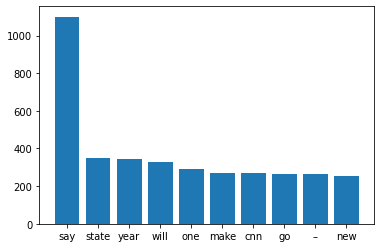

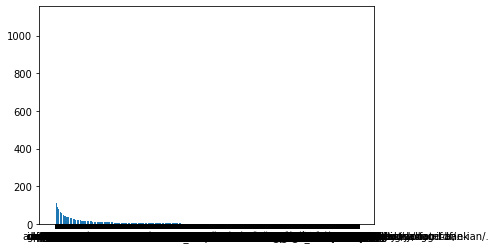

In [146]:
# produce the histogram of the top 10 words in the combined vocabulary
all_vocab = dict(sorted(all_vocab.items(), key=lambda items: items[1], reverse=True))
plotHistogram(list(all_vocab.keys())[:10], list(all_vocab.values())[:10])

# produce the histogram of all the vocabulary
all_vocab = dict(sorted(all_vocab.items(), key=lambda items: items[1], reverse=True))
plotHistogram(list(all_vocab.keys()), list(all_vocab.values()))

Task 13. Construct the word clouds from the two texts. Include the word clouds and comment your interesting insights after that.

CNN News Wordcloud:
Fox News Wordcloud:


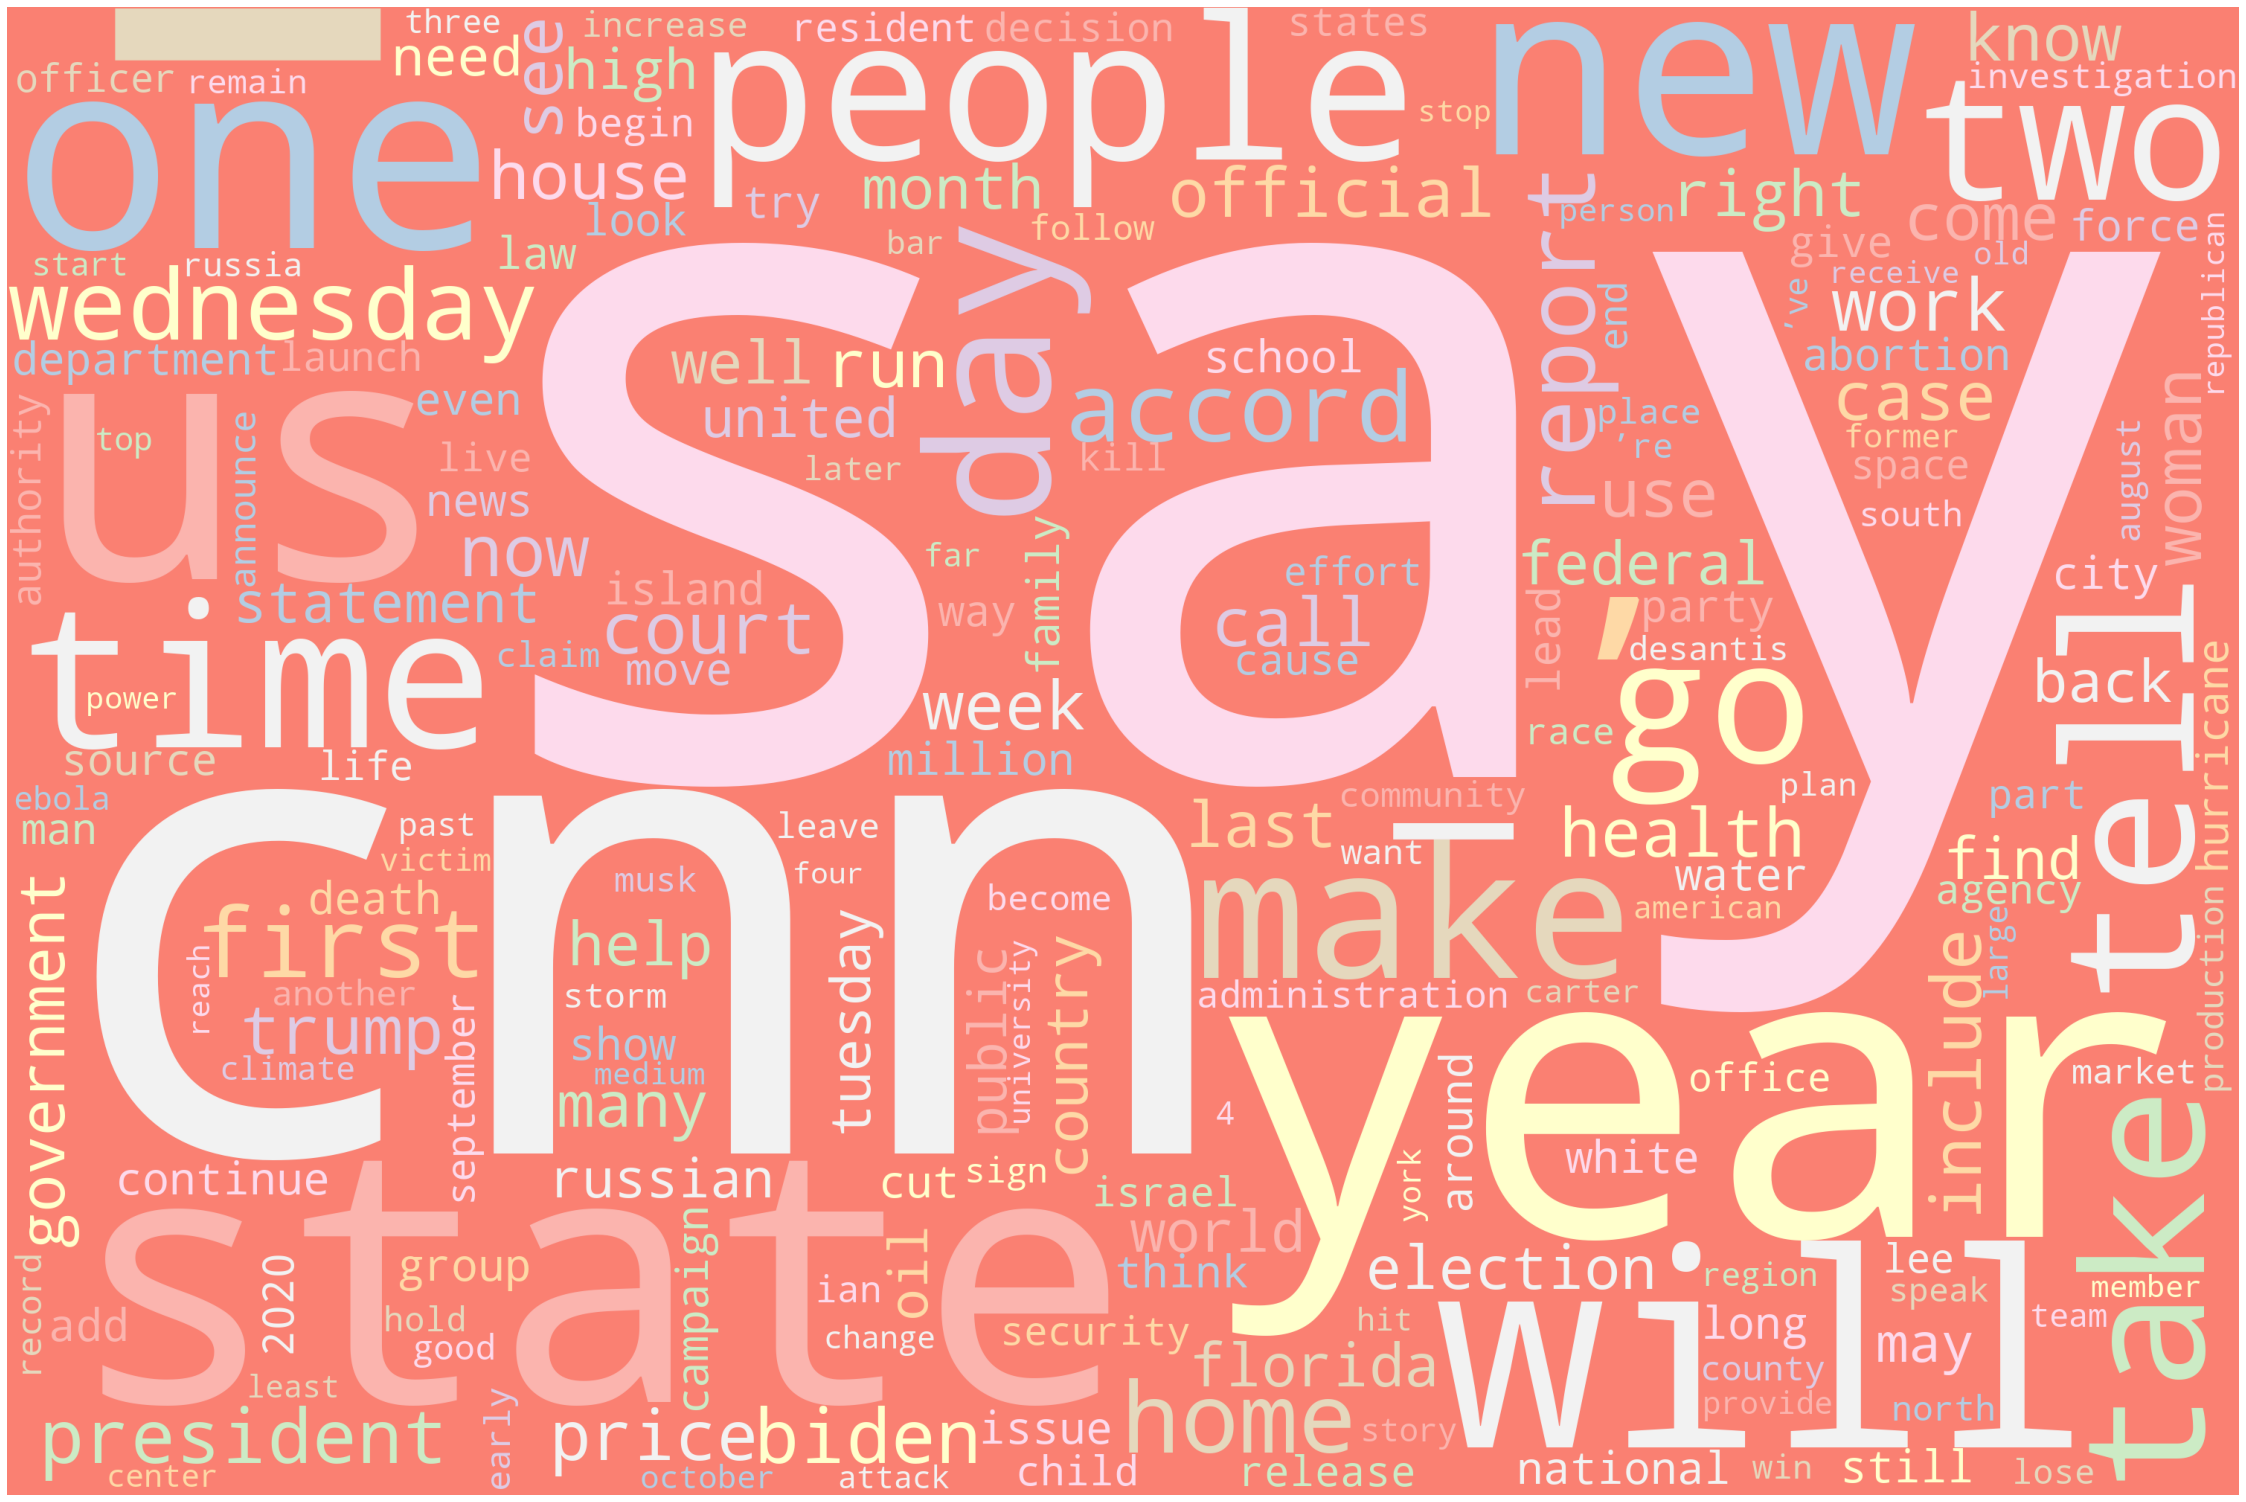

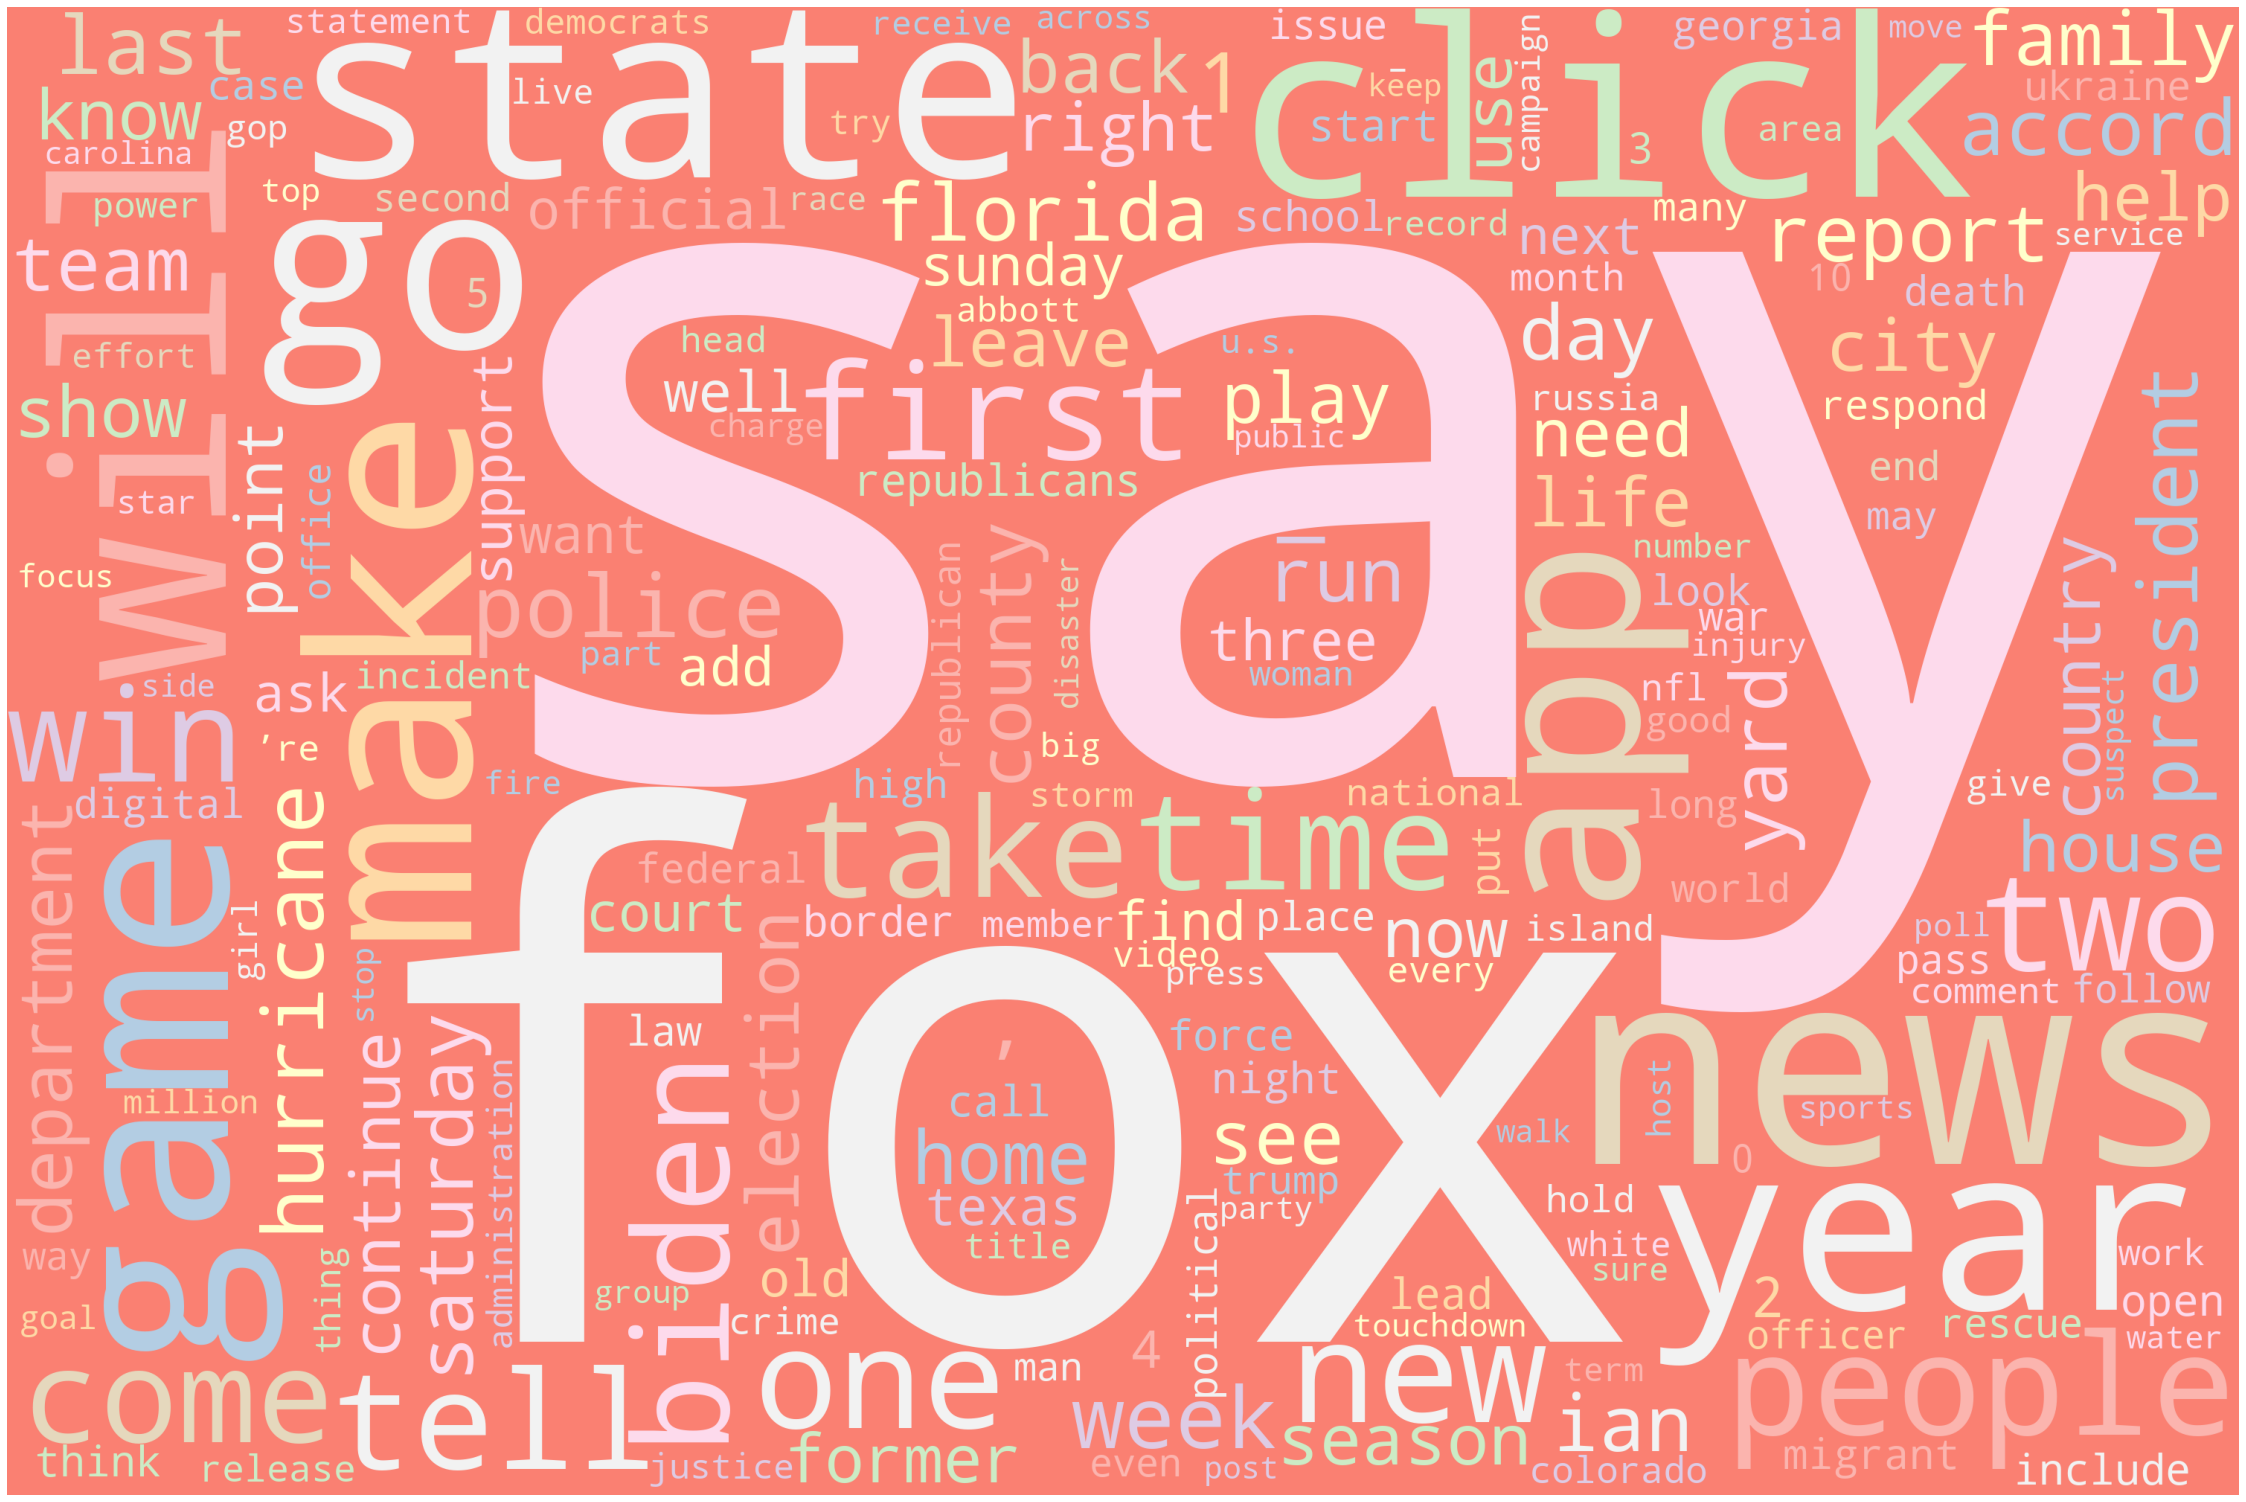

In [147]:
# You may consider re-use the code from task 5 here.

# Draw your word cloud here
cnn_wordcloud = generateWordCloud(cnn_freq)
print("CNN News Wordcloud:")
plotWordCloud(cnn_wordcloud)

fox_wordcloud = generateWordCloud(fox_freq)
print("Fox News Wordcloud:")
plotWordCloud(fox_wordcloud)

**Observations about data:**
The top words that are used in news articles are "say", "state", "year", "one", and "make", followed by the names of each news organization. In addition to these words showing up more often, there are some other reacurring wors in the news at the moment. "Florida" and "hurricane" are stand out examples due to Hurricane Ian's preseance in Florida at the moment. 